<a href="https://colab.research.google.com/github/allispaul/audiobot/blob/main/EDA/MC_Audiobots_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Erd&#337;s Institute Fall Boot Camp - Team Audiobots

We're using data from [this dataset](hhttps://huggingface.co/datasets/lewtun/music_genres_small) to try and classify one thousand 30s samples of audio into one of 10 genres:

*   International        
*   Pop                  
*   Electronic           
*   Chiptune / Glitch    
*   Punk                 
*   Folk                 
*   Hip-Hop              
*   Rock                 
*   Instrumental         
*   Experimental

The data is a .parquet file containing ~30s (uncompressed?) .wav files (I have to check bit depths and sample rates still), along with song_id (does this mean anything to anyone?), and the genre from one of the 10 categories above.

We are assuming the genres are accurate. Notably, the ``International'' genre appears to contain a variety of other genres of music, and many songs can come from more than one genre. We may eliminate this class if it causes problems.

For training, we will feed the 90\% of the data into a pre-trained Transformer network from HuggingSpace, and fine-tune the network to classify one of the 10 genres above. If the architecture requries inputs of constant size, we can either pad shorter samples with 0's, or randomly clip shorter sections of longer audio streams.

This code does the following:

*   Downloads the data from Google Drive
*   (TODO) Splits the data into a CONSISTENT training and validation set. No need to create a test set until we get to the larger datasets.
*   Calculates statistics for each class, verifying the same number of tracks in each genre, and that the size of each song is similar.
*   (TODO) Determine if there's a way to analyze the average value/volume for each track.
*   (TODO) Do we want to normalize the data in any way? I suspect Electronic music will be consistently louder than Folk music, which could throw off a (dumb) model just by changing the volume.
*   (TODO) Create a simple model to predict genre from the data
*   (TODO) Turn the data into spectrograms. This should probably be done once and saved instead of on the fly, as different settings could produce drastically different pictures.

In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
#from IPython.display import Audio

from datasets import load_dataset, Audio

/Users/kaficifci/Library/CloudStorage/OneDrive-Personal/erdos_24/audiobot/EDA/cifci_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load Data

In [48]:
# Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Alternatively, you can download the data from scratch

# !wget https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true
# spoopier way

songs = load_dataset("lewtun/music_genres_small", split='train') # https://huggingface.co/datasets/lewtun/music_genres_small
songs = songs.cast_column("audio", Audio(sampling_rate=16000)) #resampling the audio data in the dataset to a specific rate of 44100 Hz

songs

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 1000
})

In [3]:
genres = {
  0: "Electronic",
  1: "Rock",
  2: "Punk",
  3: "Experimental",
  4: "Hip-Hop",
  5: "Folk",
  6: "Chiptune / Glitch",
  7: "Instrumental",
  8: "Pop",
  9: "International"
}

## 2) Check length of the songs

In [87]:
durations_with_ids = []  # List to store tuples of (song_id, {'durations': duration})

for song in songs:
    duration = len(song['audio']['array']) / song['audio']['sampling_rate']
    durations_with_ids.append((song['song_id'], {'durations': duration}))

# To calculate total and average duration, extract the durations from the tuples
durations = [info['durations'] for _, info in durations_with_ids]
total_duration = sum(durations)  # Total duration of all songs
average_duration = total_duration / len(songs)  # Average duration of a song

print(f"Total duration of all songs: {total_duration} seconds")
print(f"Average duration of a song: {average_duration} seconds")

Total duration of all songs: 29959.228185941392 seconds
Average duration of a song: 29.95922818594139 seconds


In [109]:
# Check for outliers 

filtered_durations_with_ids = [
    (song_id, info)
    for song_id, info in durations_with_ids
    if info['durations'] < 29.5 or info['durations'] > 30.5
]

filtered_durations_with_ids # [(1975, {'durations': 1.5292290249433107})]

In [103]:
# find the index for `song_id`= 1975 

def find_song_index(songs, song_id_to_find):
    for index, song in enumerate(songs):
        if song['song_id'] == song_id_to_find:
            return index
    return None

# Example usage
song_id_to_find = 1975
index_of_song = find_song_index(songs, song_id_to_find)

index_of_song # 786

In [111]:
# Import the 30s version of the too short song and replace.

song_786, _ = librosa.load('786.wav', sr = 16000)
songs[786]['audio']['array'] = song_786 

len(songs[768]['audio']['array'])/songs[768]['audio']['sampling_rate'] 

## 3) Summary statistics

### Check number of songs in each genre

In [141]:
from collections import Counter
genre_counts = Counter(songs['genre'])

for genre, count in genre_counts.items():
    print(f"  - {genre}: {count}")

  - International: 100
  - Pop: 100
  - Electronic: 100
  - Chiptune / Glitch: 100
  - Punk: 100
  - Folk: 100
  - Hip-Hop: 100
  - Rock: 100
  - Instrumental: 100
  - Experimental: 100


### Check if all songs have same sampling rate of 16000 

In [149]:
def find_songs_with_different_rate(songs, target_rate=16000):
    different_rate_songs = []
    for song in songs:
        if song['audio']['sampling_rate'] != target_rate:
            different_rate_songs.append(song)
    return different_rate_songs

songs_with_different_rate = find_songs_with_different_rate(songs)

songs_with_different_rate # empty => all songs have a sampling rate of 44100

[]

### Example 2D representation of sound waves for Song 1

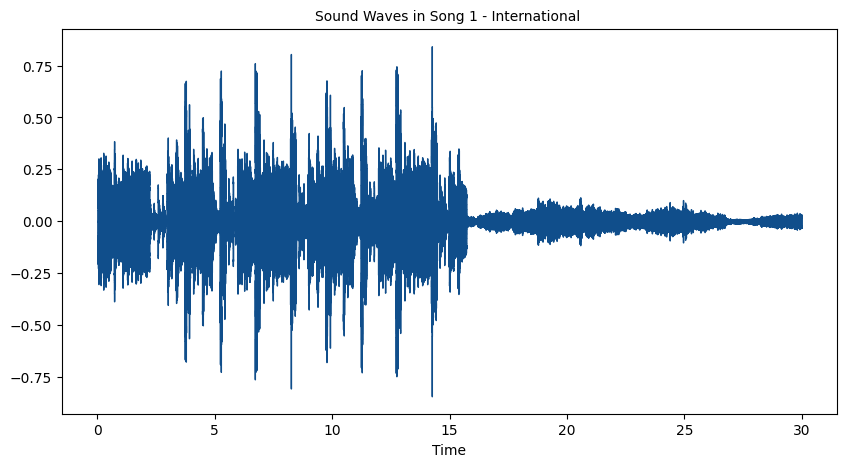

In [178]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize = (10, 5))
librosa.display.waveshow(y = songs[1]['audio']['array'], sr = 16000, color = "#104e8b");
plt.title("Sound Waves in Song 1 - International ", fontsize = 10);

### Explore Fourier Transform ; gets signal in time as input and outputs decomposition into frequencies

In [171]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(songs[1]['audio']['array'], n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 2585)


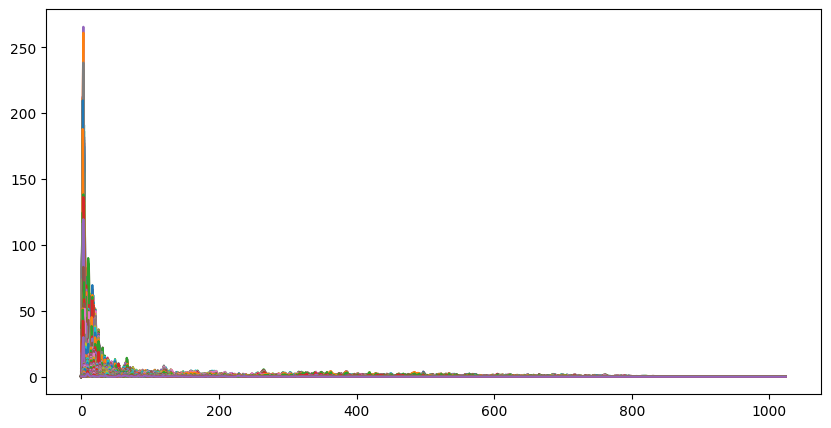

In [179]:
plt.figure(figsize = (10, 5))
plt.plot(D);

### Explore Spectogram 

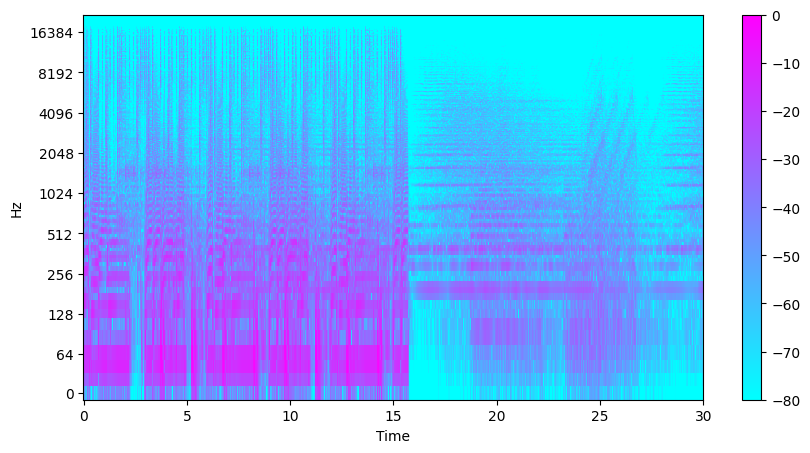

In [180]:
# Spectogram is visual representation of spectrum of frequencies of a signal as it varies across time.

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Plot 
plt.figure(figsize = (10, 5))
librosa.display.specshow(DB, sr = 16000, hop_length = hop_length, x_axis = 'time', y_axis = 'log', # take log of frequency axis 
                        cmap = 'cool') 
plt.colorbar();

## 4) Audio Features

### Zero crossing rate 

In [181]:
# rate at which audio signal changes its sign.

# song 1 
zero_crossings = librosa.zero_crossings(songs[1]['audio']['array'], pad=False)
print(sum(zero_crossings))

48188


### Harmonics and Perceptrual

In [182]:
# Harmonics = multiplies of a fundamental frequency in a sound wave. musical note 100 Hz -> 2nd harmonic would be 200 Hz. 
# Harmonics is used to understand spectral content of a sound (eg. pitch detection, transcription)

# Perceptrual represents sound rhythm and emotion 

y_harm, y_perc = librosa.effects.hpss(songs[1]['audio']['array'])

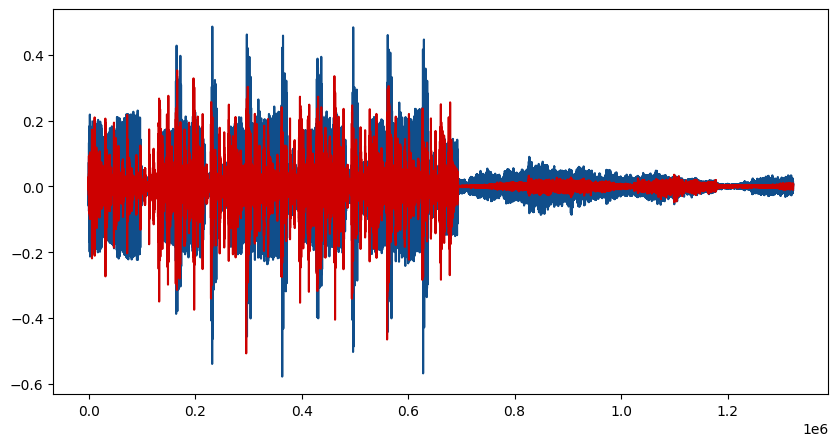

In [185]:
plt.figure(figsize = (10, 5))
plt.plot(y_harm, color = '#104e8b'); # blue -> harmonics 
plt.plot(y_perc, color = '#cd0000'); # red -> perceptrual

### Chroma Frequencies

Chromogram shape: (12, 265)
Chroma stft mean: 0.4714727007275175


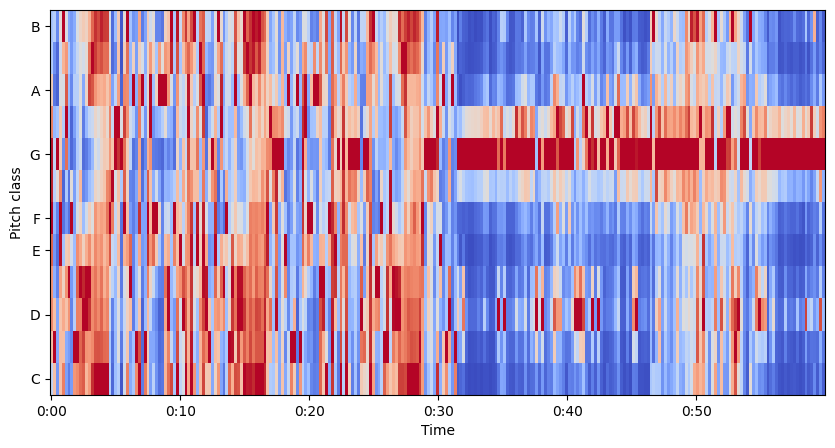

In [205]:
# capture harmonic and melodic characteristics by summarizing energy distribution across 12 pitch classes.

# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=songs[1]['audio']['array'], sr=16000, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)
print('Chroma stft mean:', chromagram.mean()) # short-time fourier transform

plt.figure(figsize=(10, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap="coolwarm");

### Spectral Centroid 
location for centre of mass for a sound. Calculated as weighted mean of frequencies. 


### Spectral Roloff

Spectral shape of audio signal.

### Mel-freq cepstral coefficients

### Tempo beats per minute

In [198]:
tempo, _ = librosa.beat.beat_track(y=songs[1]['audio']['array'], sr=16000)
print(tempo)

161.4990234375


### Tempo beats per minute by genre

In [206]:
# Get tempo bpm for each song
tempo_genre_data = []
for song in songs:
    y = song['audio']['array']
    tempo, _ = librosa.beat.beat_track(y=y, sr=16000)
    genre = song['genre']
    tempo_genre_data.append((tempo, genre))

In [207]:
# Group tempos by genre
tempo_by_genre = {}
for tempo, genre in tempo_genre_data:
    if genre not in tempo_by_genre:
        tempo_by_genre[genre] = []
    tempo_by_genre[genre].append(tempo)

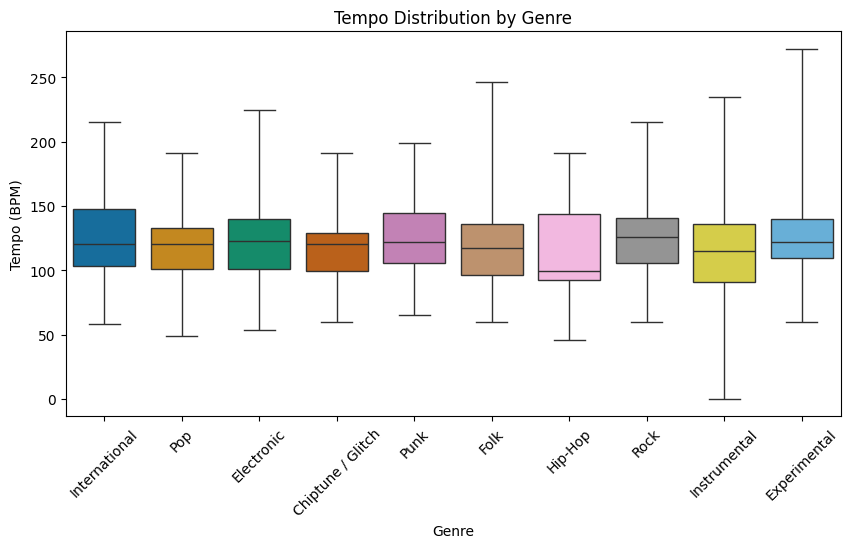

In [212]:
# box-whisker plot for tempo distribution by genre 
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.boxplot(data=[tempo_by_genre[genre] for genre in tempo_by_genre], 
            whis=np.inf, 
            palette="colorblind")
plt.xticks(ticks=range(len(tempo_by_genre)), labels=tempo_by_genre.keys(), rotation=45)
plt.ylabel('Tempo (BPM)')
plt.xlabel('Genre')
plt.title('Tempo Distribution by Genre')
plt.show()